In [ ]:
!pip install dwave-ocean-sdk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.1/232.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install dimod


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite

# 1. Load digits dataset
digits = datasets.load_digits()
X = digits.data
y = digits.target

# 2. Convert to binary classification: e.g., classify '0' vs 'not 0'
y_binary = np.where(y == 0, 1, 0)

# 3. Dimensionality reduction (too many features otherwise)
X = StandardScaler().fit_transform(X)
X = PCA(n_components=10).fit_transform(X)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# 5. Build QUBO for classification
# Basic linear classifier QUBO: minimize (y - Xw)^2 → w is binary vector
# Here we use a toy model with binary weights

def build_qubo(X, y, lambda_reg=0.1):
    n_features = X.shape[1]
    Q = {}

    for i in range(n_features):
        for j in range(n_features):
            Q[(i, j)] = lambda_reg * np.dot(X[:, i], X[:, j])
        Q[(i, i)] -= 2 * np.dot(X[:, i], y)
    return Q

qubo = build_qubo(X_train, y_train)

# 6. Solve QUBO using D-Wave (or local simulator)
# sampler = EmbeddingComposite(DWaveSampler())
# sampleset = sampler.sample_qubo(qubo, num_reads=100)

# Use ExactSolver for small problems (local test)
from dimod.reference.samplers import ExactSolver
sampler = ExactSolver()
sampleset = sampler.sample_qubo(qubo)

best_sample = sampleset.first.sample
weights = np.array([best_sample[i] for i in range(X_train.shape[1])])

# 7. Predict on test set
y_pred = (np.dot(X_test, weights) > 0.5).astype(int)

# 8. Evaluate
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
from google.colab import files
from IPython.display import Image, display


Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       327
           1       0.25      0.85      0.38        33

    accuracy                           0.75       360
   macro avg       0.61      0.79      0.61       360
weighted avg       0.91      0.75      0.80       360



Saving WhatsApp Image 2025-05-08 at 6.20.45 PM.jpeg to WhatsApp Image 2025-05-08 at 6.20.45 PM (3).jpeg


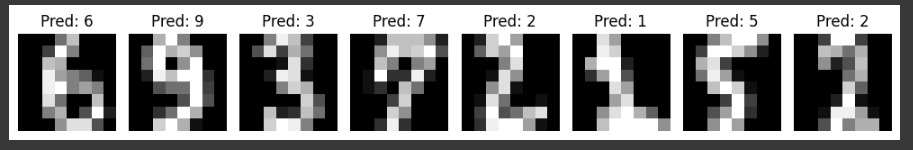

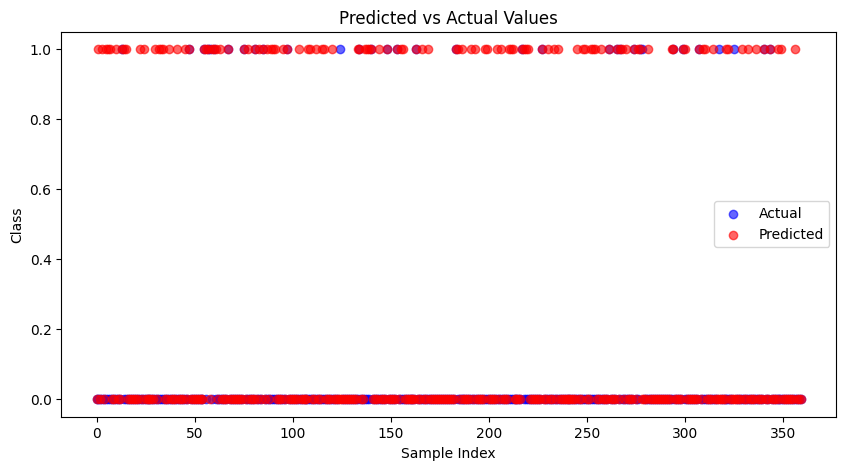

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not 0', '0'], yticklabels=['Not 0', '0'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Upload image
uploaded = files.upload()

# Display the uploaded image
for file_name in uploaded.keys():
    #print(f"Displaying image: {file_name}")
    display(Image(file_name))

# Predicted vs Actual
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted', alpha=0.6)
plt.title('Predicted vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.show()

